# Håndtering av georeferert data i Python

Det finnes flere open source biblioteker som kan brukes til å håndtere GeoTiffer, shapefiler og annen geodata i python. De er i hovedsak bygget på [GDAL](https://gdal.org/)

*rasterio* er et eksempel på et populært høynivå bibliotek som pakker GDAL funksjonalitet inn i et "pythonsk" format.

### Lagring og bruk av geotransform

I fila `geoutils.py` har vi implementert en enkel klasse `GeoImage` som bruker rasterio til å lese GeoTiffer og lagrer både bildedataen og georefereringen til et bilde.

In [1]:
# legg til src i path
from pathlib import Path
import sys

src_path = Path(".").absolute().parent / Path('src')
sys.path.append(src_path.__str__())

from geoutils import GeoImage



In [4]:
# test på et satelittbile over Oslo

fil = "data/Oslo_GE_basemap.tif"
image = GeoImage(fil)

In [5]:
# et objekt i klassen har følgende variabler

image.__dict__.keys()

dict_keys(['filepath', 'ROI', 'original', 'bounds', 'metadata'])

In [6]:
# inspiser de ulike variablene
# ....

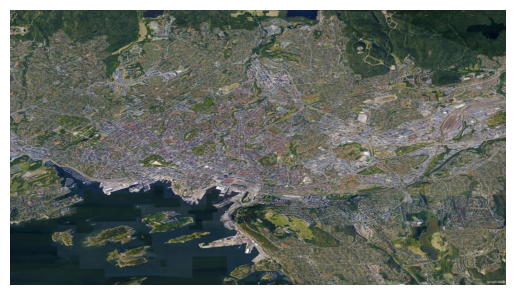

In [7]:
# vis frem bildet
image.preview()

`geoutils` inneholder også en funksjon `CopyGeoTransform` som gjør at man kan ta georeferering til et GeoImage, og lage et nytt GeoImage med samme geotransform og metdata, men med ny bildedata. Dette kan være nyttig dersom man f.eks har lagt til bounding boxer eller segmentering på et bilde ved hjelp av maskinlæring i python, og ønsker å lagre de som en GeoTiff som kan åpnes i et GIS program.

*NB!* Den nye bildedataen må være av samme størrelse og oppløsning som den opprinnelige for at georefereingen skal bli riktig.

In [8]:
# som eksempel kan vi kopiere dataen fra bildet over og manipulere den.
new_image_data = image.data.copy()

# endre på fargene i en firkant
new_image_data[0,200:500,200:400] = 200

In [9]:
from geoutils import CopyGeoTransform

# lag et nytt GeoImage med den nye dataen, og bestem hva GeoTiffen skal hete
edited_image = CopyGeoTransform(image,new_image_data,"data/redigert_Oslo_basemap.tif")

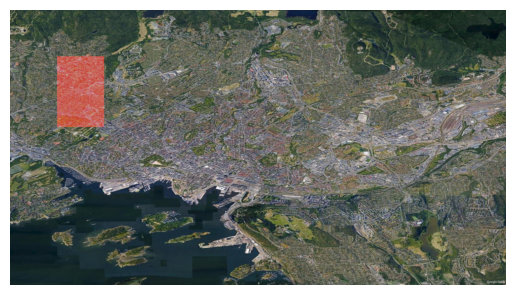

In [10]:
# se på det nye bildet

edited_image.preview()

Det bør nå ligge en nye Geotiff av det redigerte bildet i /data/ 

### Maskering og ROI

I `GeoImage` klassen har vi også inkluder funksjonalitet for å velge ut et interesseområde med en maske. Dette kan gjøres ved hjelp av polygoner definert i en Shapefile eller GeoJson.

Funksjonen `readPolygon` leser denne typen filer, og konverterer det til en liste med dictionaries det polygonene i fila er lagret på i Python geo interface protocol.

In [11]:
from geoutils import readPolygon

maske = readPolygon("data/OsloRing3/OsloRing3.shp")

print(maske)

[{'type': 'Polygon', 'coordinates': (((10.676321475530203, 59.92086803361809), (10.675647337658415, 59.93505574710616), (10.703286990401784, 59.944454579946466), (10.708680093376099, 59.946424057560655), (10.718455092517049, 59.94591763163451), (10.73384790725624, 59.95098154277777), (10.751375491922769, 59.952838116376554), (10.768453651341437, 59.953738235838266), (10.776880374738806, 59.94957497839024), (10.784857672888315, 59.936913212700745), (10.810699624640245, 59.92773744622267), (10.8198004859094, 59.90785729882858), (10.78519474182421, 59.89957508485328), (10.753847330785996, 59.897264711175204), (10.704185840897503, 59.905547501284666), (10.676321475530203, 59.92086803361809)),)}]


Vi kan sette interesseområde-masken på bildet vårt. Og velge nodata-verdi, med metoden `setROI`.

In [12]:
image.setROI(maske)

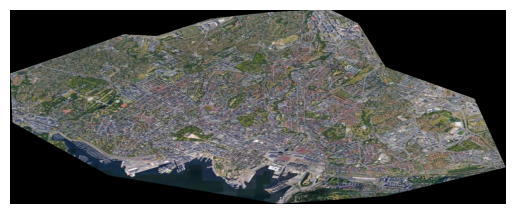

In [13]:
# se på preview på nytt

image.preview()

Så lenge `image.ROI` er definert, vil klassen som default peke til `ROI["data"]` og `ROI["transform"]`, men det orginale bildet er fortsatt tilgengelig under `image.original["data"]` of `image.original["transform"]`.

For å fjærne interesseområde setter man ganske enkelt `image.ROI = None`.

Dersom man har gjort endringer i dataen, transformen eller ROI-en til et `GeoImage` og ønsker å lagre den nye versjonen, kan man kalle `save` funksjonen.

In [14]:
image.save("data/Oslo_GE_Ring3.tif")